In [28]:
import numpy as np

import torch
import torch.nn as nn

import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid

from visualbackprop import ResnetVisualizer

import matplotlib.pyplot as plt

In [29]:
%run utils.py

In [30]:
!pwd

/home/penn/projects/recycle/classify


In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)

model.load_state_dict(torch.load('saved_models/model_4.pt'))
model = model.to(device)

In [32]:
valid_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


trainset = datasets.ImageFolder(
    '../data/recycle_classify/train', valid_transform)

validset = datasets.ImageFolder(
    '../data/recycle_classify/valid', valid_transform)

In [17]:
def tensor_to_img(T):
    img = T.transpose(0,2).cpu().numpy()
    return np.interp(img, [img.min(), img.max()], [0, 1])

In [18]:
def get_data(dataset, model, batch_size=32):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model.eval()
    loader = DataLoader(dataset, batch_size=batch_size)
    preds = []
    cross_entropy = []
    for images, labels in loader:

        with torch.set_grad_enabled(False):
            images = images.to(device)
            labels = labels.to(device)
            probs = model(images)
            preds += [probs.argmax(-1)]
            cross_entropy += [nn.functional.cross_entropy(probs, labels, reduction='none')]
    return torch.cat(preds, 0), torch.cat(cross_entropy, 0)

In [ ]:
def display_top(model, dataset, rows=3, cols=3, best=False):

Lets find the top images from the training set (i.e data we are potentially overfitting), and the worst images from the validation set

In [19]:
rows, cols = 3,3
preds, cross_entropy = get_data(validset, model)
values, args = torch.topk(cross_entropy, k=rows*cols)        # Indices of images with highest cross_entropy

In [20]:
images, labels = zip(*[validset[i] for i in args])

In [21]:
validset.classes

['glass', 'metal', 'plastic']

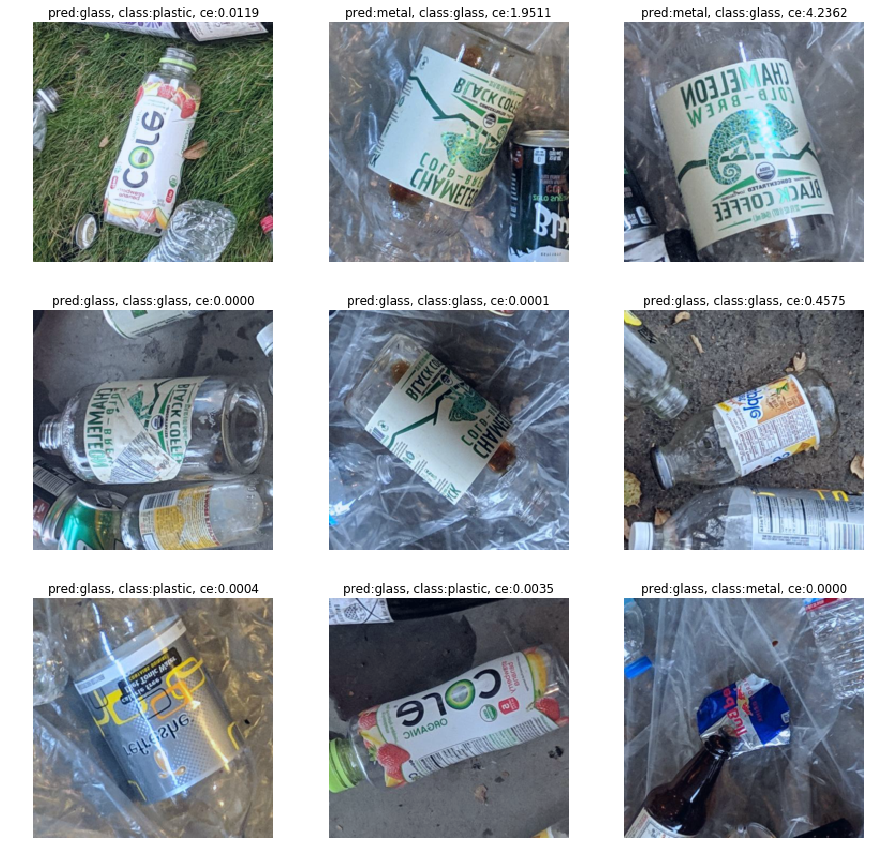

In [25]:
#grid = make_grid(images, nrow=rows, normalize=True, scale_each=True, padding=10)
with torch.set_grad_enabled(False):
    model.eval()
    fig, axs = plt.subplots(rows, cols, figsize=(15,15))
    for image, pred, label, ce, ax in zip(images, preds, labels, cross_entropy, axs.ravel()):
        ax.imshow(tensor_to_img(image))
        ax.axis('off')
        _pred = validset.classes[pred]
        _label = validset.classes[label]
        ax.set_title(f'pred:{_pred}, class:{_label}, ce:{ce:.4f}')

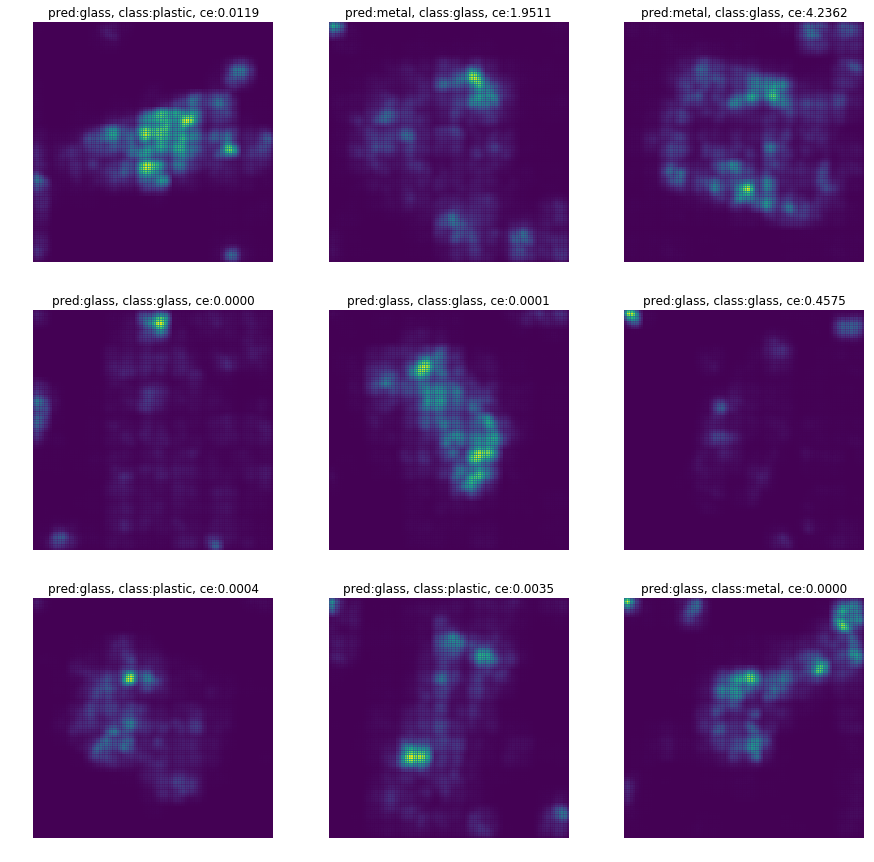

In [27]:
#grid = make_grid(images, nrow=rows, normalize=True, scale_each=True, padding=10)
with torch.set_grad_enabled(False):
    model.eval()
    model_vis = ResnetVisualizer(model.to("cpu"))
    fig, axs = plt.subplots(rows, cols, figsize=(15,15))
    for image, pred, label, ce, ax in zip(images, preds, labels, cross_entropy, axs.ravel()):
        _, vis = model_vis(image.unsqueeze(0))
        ax.imshow(vis.squeeze(0).squeeze(0).numpy())
        ax.axis('off')
        _pred = validset.classes[pred]
        _label = validset.classes[label]
        ax.set_title(f'pred:{_pred}, class:{_label}, ce:{ce:.4f}')